In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import math
import warnings


warnings.filterwarnings('ignore')

# Mostrar todas las columnas
pd.set_option('display.max_columns', None)

In [2]:
import json

# Leer el JSON
with open("./datasets/clean_listings_dtypes.json", "r") as f:
    info = json.load(f)

dtypes_str = info["dtypes"]
categorical_cols = info["categoricals"]

# Convertir strings de tipo a los tipos correctos
def convertir_dtype(dtype_str):
    if dtype_str.startswith("int"): return "Int64"
    if dtype_str.startswith("float"): return "float"
    if dtype_str == "object": return "string"
    if dtype_str == "bool": return "boolean"
    return "string"

normal_dtypes = {col: convertir_dtype(dtype) for col, dtype in dtypes_str.items()}

# Carga el dataset
file_path = "./datasets/clean_listings.csv"
df_fe = pd.read_csv(file_path)



for col in categorical_cols:
    df_fe[col] = df_fe[col].astype("category")




In [3]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

# neighbourhood
neighbourhood_categories = sorted(df_fe["neighbourhood_cleansed"].unique())
ordinal_encoder = OrdinalEncoder(categories=[neighbourhood_categories])
df_fe["neighbourhood_encoded"] = ordinal_encoder.fit_transform(df_fe[["neighbourhood_cleansed"]]).astype(int)
df_fe.head(10)

# room_type
room_type_categories = sorted(df_fe["room_type"].unique())
ordinal_encoder = OrdinalEncoder(categories=[room_type_categories])
df_fe["room_type_encoded"] = ordinal_encoder.fit_transform(df_fe[["room_type"]]).astype(int)
df_fe.head(10)

# property_type
property_type_categories = sorted(df_fe["property_type"].unique())
ordinal_encoder = OrdinalEncoder(categories=[property_type_categories])
df_fe["property_type_encoded"] = ordinal_encoder.fit_transform(df_fe[["property_type"]]).astype(int)

# reviews (discretización)
df_fe['reviews_bin'] = pd.qcut(df_fe['number_of_reviews'], q=4, labels=['Bajo', 'Medio', 'Alto', 'Muy alto'])

# availability_365 (discreatización)
df_fe['availability_bin'] = pd.qcut(df_fe['availability_365'], q=4, labels=['Bajo', 'Medio', 'Alto', 'Muy alto'])

df_fe.head(10)

,host_id,price,room_type,property_type,neighbourhood_cleansed,accommodates,bedrooms,beds,minimum_nights,maximum_nights,availability_365,number_of_reviews,review_scores_rating,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,reviews_per_month,instant_bookable,latitude,longitude,missing_count,neighbourhood_encoded,room_type_encoded,property_type_encoded,reviews_bin,availability_bin
0,191042082,36758.0,Entire home/apt,Entire rental unit,Agronomia,2,1.0,3.0,3,1125,73,15,4.67,4.67,5.00,5.00,5.00,0.20,False,-34.592970,-58.492990,0,0,0,16,Alto,Bajo
1,137427072,37000.0,Entire home/apt,Entire rental unit,Agronomia,3,0.0,2.0,3,180,179,15,4.93,4.73,4.80,4.93,4.80,0.22,False,-34.596500,-58.488490,0,0,0,16,Alto,Medio
2,385856273,28356.0,Entire home/apt,Entire rental unit,Agronomia,2,1.0,1.0,2,1125,328,67,4.87,4.73,4.93,4.97,4.88,1.39,False,-34.597260,-58.482780,0,0,0,16,Muy alto,Alto
3,895346,74475.0,Entire home/apt,Entire rental unit,Agronomia,4,2.0,3.0,3,27,168,17,4.82,4.94,4.94,4.88,4.82,0.47,False,-34.596390,-58.486430,0,0,0,16,Alto,Medio
4,225695530,43809.0,Entire home/apt,Entire rental unit,Agronomia,2,1.0,1.0,2,90,364,1,5.00,4.00,4.00,5.00,4.00,0.05,False,-34.592950,-58.496740,0,0,0,16,Bajo,Muy alto
5,467311712,35707.0,Entire home/apt,Entire condo,Agronomia,3,1.0,2.0,4,1125,14,11,4.82,4.64,5.00,5.00,4.45,0.37,True,-34.597530,-58.485170,0,0,0,8,Medio,Bajo
6,32973396,50263.0,Entire home/apt,Entire condo,Agronomia,4,1.0,3.0,1,365,364,31,4.68,4.74,4.84,4.77,4.71,1.36,False,-34.597280,-58.483270,0,0,0,8,Alto,Muy alto
7,482355671,42009.0,Entire home/apt,Entire condo,Agronomia,3,1.0,3.0,3,90,3,13,4.85,4.62,5.00,5.00,4.85,0.46,False,-34.591889,-58.491294,0,0,0,8,Medio,Bajo
8,467311712,42009.0,Entire home/apt,Entire condo,Agronomia,3,1.0,2.0,3,1125,58,17,4.94,4.88,5.00,5.00,4.88,0.64,True,-34.596710,-58.484410,0,0,0,8,Alto,Bajo
9,32973396,54611.0,Entire home/apt,Entire condo,Agronomia,4,1.0,4.0,3,365,365,18,4.72,4.78,4.78,4.72,4.78,0.70,True,-34.596920,-58.484660,0,0,0,8,Alto,Muy alto


Nuevas variables:

In [4]:

from sklearn.cluster import KMeans

# Precio por persona
df_fe['price_per_person'] = df_fe['price'] / df_fe['accommodates']

# Precio por cama
df_fe['price_per_bed'] = df_fe['price'] / df_fe['beds'].replace(0, np.nan)

# Ratio de reviews por año
df_fe['reviews_per_year'] = df_fe['reviews_per_month'] * 12

# Precio elevado
df_fe['expensive'] = (df_fe['price'] > df_fe['price'].quantile(0.90)).astype(int)

# propiedad muy comentada (top 10%)
review_threshold = df_fe['number_of_reviews'].quantile(0.90)

# Es altamente calificado
df_fe['highly_reviewed'] = (df_fe['number_of_reviews'] >= review_threshold).astype(int)

# Log-transform para min_nights para facilitar la visualización
df_fe['min_nights_log'] = np.log1p(df_fe['minimum_nights'])

# Agrupar por barrio y aplicar KMeans dentro de cada grupo
df_fe['geo_subcluster'] = -1  # Inicializamos con un valor inválido

for neigh in df_fe['neighbourhood_cleansed'].unique():
    mask = df_fe['neighbourhood_cleansed'] == neigh
    coords = df_fe.loc[mask, ['latitude', 'longitude']]

    if len(coords) >= 10:  # Solo si hay suficientes puntos
        kmeans = KMeans(n_clusters=10, random_state=42)
        df_fe.loc[mask, 'geo_subcluster'] = kmeans.fit_predict(coords)
    else:
        # Si hay pocos puntos, los dejamos todo
        df_fe.loc[mask, 'geo_subcluster'] = 0

df_fe.head(200)

,host_id,price,room_type,property_type,neighbourhood_cleansed,accommodates,bedrooms,beds,minimum_nights,maximum_nights,availability_365,number_of_reviews,review_scores_rating,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,reviews_per_month,instant_bookable,latitude,longitude,missing_count,neighbourhood_encoded,room_type_encoded,property_type_encoded,reviews_bin,availability_bin,price_per_person,price_per_bed,reviews_per_year,expensive,highly_reviewed,min_nights_log,geo_subcluster
0,191042082,36758.0,Entire home/apt,Entire rental unit,Agronomia,2,1.0,3.0,3,1125,73,15,4.67,4.67,5.00,5.00,5.00,0.20,False,-34.59297,-58.49299,0,0,0,16,Alto,Bajo,18379.000000,12252.666667,2.40,0,0,1.386294,6
1,137427072,37000.0,Entire home/apt,Entire rental unit,Agronomia,3,0.0,2.0,3,180,179,15,4.93,4.73,4.80,4.93,4.80,0.22,False,-34.59650,-58.48849,0,0,0,16,Alto,Medio,12333.333333,18500.000000,2.64,0,0,1.386294,0
2,385856273,28356.0,Entire home/apt,Entire rental unit,Agronomia,2,1.0,1.0,2,1125,328,67,4.87,4.73,4.93,4.97,4.88,1.39,False,-34.59726,-58.48278,0,0,0,16,Muy alto,Alto,14178.000000,28356.000000,16.68,0,0,1.098612,8
3,895346,74475.0,Entire home/apt,Entire rental unit,Agronomia,4,2.0,3.0,3,27,168,17,4.82,4.94,4.94,4.88,4.82,0.47,False,-34.59639,-58.48643,0,0,0,16,Alto,Medio,18618.750000,24825.000000,5.64,0,0,1.386294,3
4,225695530,43809.0,Entire home/apt,Entire rental unit,Agronomia,2,1.0,1.0,2,90,364,1,5.00,4.00,4.00,5.00,4.00,0.05,False,-34.59295,-58.49674,0,0,0,16,Bajo,Muy alto,21904.500000,43809.000000,0.60,0,0,1.098612,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,45244004,18904.0,Entire home/apt,Entire rental unit,Almagro,3,1.0,2.0,10,1125,214,0,4.88,4.84,4.95,4.96,4.94,0.93,False,-34.60087,-58.42356,0,1,0,16,Bajo,Medio,6301.333333,9452.000000,11.16,0,0,2.397895,8
196,22285522,35000.0,Entire home/apt,Entire rental unit,Almagro,3,1.0,3.0,3,20,64,0,4.88,4.84,4.95,4.96,4.94,0.93,False,-34.60431,-58.42378,0,1,0,16,Bajo,Bajo,11666.666667,11666.666667,11.16,0,0,1.386294,1
197,229275787,89268.0,Entire home/apt,Entire rental unit,Almagro,2,1.0,2.0,3,30,324,4,4.75,4.50,4.25,5.00,5.00,0.06,True,-34.60036,-58.41900,0,1,0,16,Medio,Alto,44634.000000,44634.000000,0.72,1,0,1.386294,0
198,229275787,57615.0,Entire home/apt,Entire condo,Almagro,2,1.0,2.0,3,1125,308,4,4.25,4.50,4.25,4.25,4.75,0.06,True,-34.60038,-58.41887,0,1,0,8,Medio,Alto,28807.500000,28807.500000,0.72,0,0,1.386294,0


In [5]:
# Filtra solo columnas numéricas
df_numericas = df_fe.select_dtypes(include=['number'])

# Mostrarlas con sus tipos
for col in df_numericas.columns:
    print(f"{col}: {df_numericas[col].dtype}")


price: float64
accommodates: int64
bedrooms: float64
beds: float64
minimum_nights: int64
maximum_nights: int64
availability_365: int64
number_of_reviews: int64
review_scores_rating: float64
review_scores_cleanliness: float64
review_scores_checkin: float64
review_scores_communication: float64
review_scores_location: float64
reviews_per_month: float64
latitude: float64
longitude: float64
missing_count: int64
neighbourhood_encoded: int64
room_type_encoded: int64
property_type_encoded: int64
price_per_person: float64
price_per_bed: float64
reviews_per_year: float64
expensive: int64
highly_reviewed: int64
min_nights_log: float64
geo_subcluster: int64


### 2 Reducción por PCA

In [27]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 1. Selección de columnas numéricas relevantes
cols_num = [
    'price',
    'accommodates',
    'bedrooms',
    'beds',
    'availability_365',
    'review_scores_rating',
    'reviews_per_month',
    'price_per_person',
    'price_per_bed',
    'reviews_per_year'   
];

# 2. Filtrar las columnas y eliminar NaNs
df_pca = df_fe[cols_num].dropna().copy()

# 3. Escalar los datos
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_pca)

# 4. Aplicar PCA para reducir a 2 dimensiones
pca = PCA(n_components=6)
components = pca.fit_transform(scaled_data)

# 5. Resultado como DataFrame para graficar o analizar
df_components = pd.DataFrame(components, columns=['PC1', 'PC2','PC3', 'PC4','PC5', 'PC6'])

# (Opcional) Información adicional: Driver, Team, etc.
df_components['accommodates'] = df_fe.loc[df_pca.index, 'accommodates'].values
df_components['accommodates'] = df_components['accommodates'].astype("category")
df_components.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29626 entries, 0 to 29625
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   PC1           29626 non-null  float64 
 1   PC2           29626 non-null  float64 
 2   PC3           29626 non-null  float64 
 3   PC4           29626 non-null  float64 
 4   PC5           29626 non-null  float64 
 5   PC6           29626 non-null  float64 
 6   accommodates  29626 non-null  category
dtypes: category(1), float64(6)
memory usage: 1.4 MB


In [21]:
df_components

,PC1,PC2,PC3,PC4,PC5,PC6,accommodates
0,-0.237765,-0.267273,-1.611116,-0.842798,-0.881524,-0.444985,2
1,0.188175,-0.865635,-1.317034,-0.595679,0.347019,-1.485734,3
2,0.433311,-1.052417,-0.012858,0.567639,0.803299,0.513045,2
3,-1.017617,1.836289,-0.930010,-0.577957,-0.222385,0.254226,4
4,1.610719,0.079176,-0.876757,0.399295,1.342284,0.372388,2
...,...,...,...,...,...,...,...
29621,0.259926,-1.983792,-0.327057,0.683563,0.923768,0.801874,1
29622,-3.334248,0.709247,-2.108045,1.576206,0.403249,-1.738881,6
29623,-0.768102,-1.595315,-1.068413,0.754838,1.296200,0.253581,2
29624,0.516734,-1.890897,-0.818228,-1.454465,-0.740008,0.651058,1


#### Graficos de los componentes

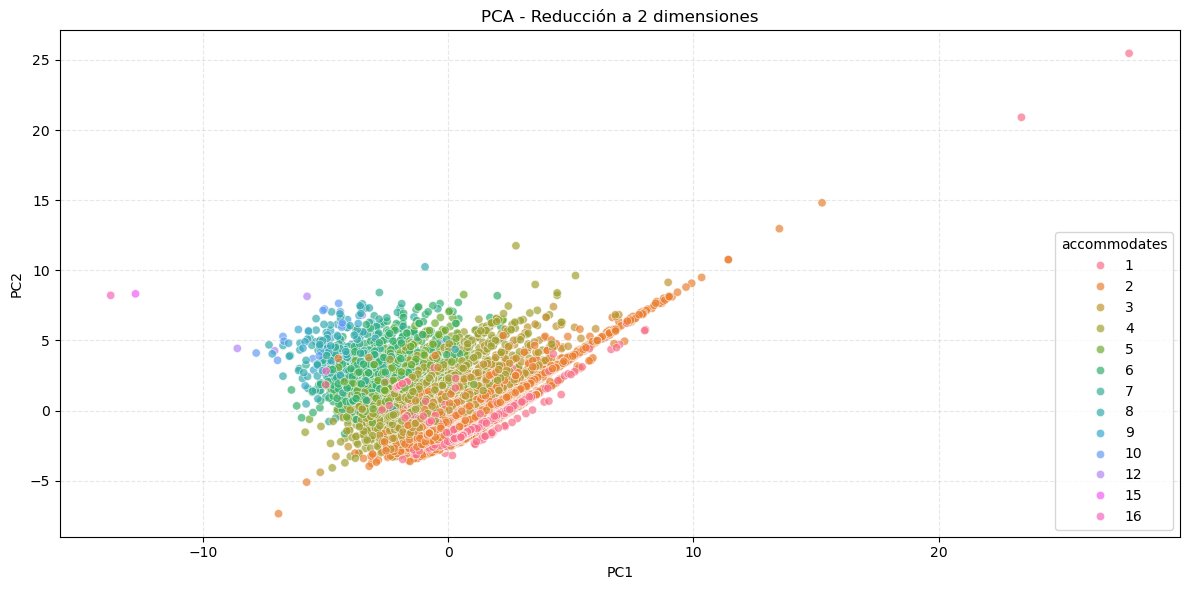

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.scatterplot(data=df_components, x='PC1', y='PC2', hue='accommodates', alpha=0.7)
plt.title("PCA - Reducción a 2 dimensiones")
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


In [30]:
# varianza explicada por cada componente
explained_var = pca.explained_variance_ratio_
explained_var

array([0.26022413, 0.25154188, 0.19401353, 0.10286829, 0.09301852,
       0.05064077])

In [31]:
# varianza acumulada
cumulative_var = np.cumsum(explained_var)
cumulative_var

array([0.26022413, 0.51176601, 0.70577954, 0.80864783, 0.90166635,
       0.95230711])

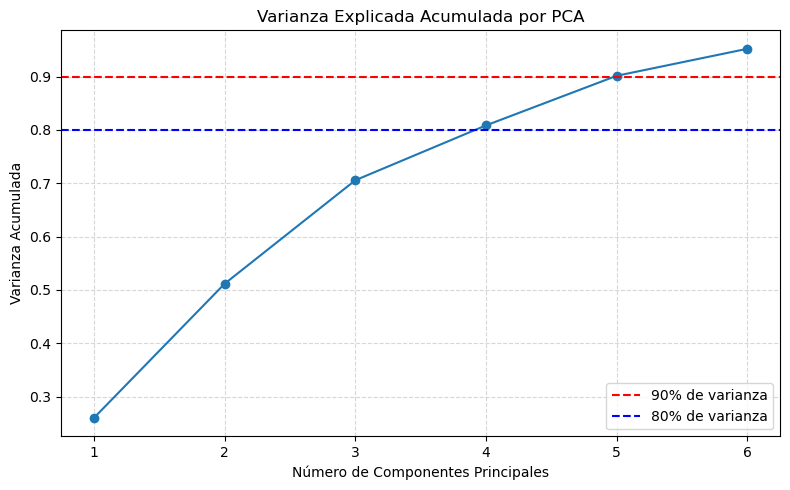

In [32]:
# Gráfico
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_var) + 1), cumulative_var, marker='o', linestyle='-')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Acumulada')
plt.title('Varianza Explicada Acumulada por PCA')
plt.axhline(y=0.9, color='red', linestyle='--', label='90% de varianza')
plt.axhline(y=0.8, color='blue', linestyle='--', label='80% de varianza')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()
